# Assignment Set 6
by **Amir Mehrpanah** for Deep Learing Course at Data Science Center, SBU



## Preprocessing

In [ ]:
#@title Reading The Data
df = pd.read_csv('data/HRDataset.csv').drop(columns=['Employee_Name',
                                                     'ManagerName',
                                                     'Zip',
                                                     'Position',
                                                     'MaritalDesc',
                                                     'MarriedID',
                                                     'Sex',
                                                     'State',
                                                     'PerformanceScore',
                                                     'Department',
                                                     'EmploymentStatus',
                                                     'DaysLateLast30', # too many nulls
                                                     'LastPerformanceReview_Date', # too many nulls
                                                     'EmpID'])

In [ ]:
#@title Cleaning Data

# remove that yellow part!
cleandf = df.dropna(how='all')

# just one case in TermReason column majority imputing method
cleandf['TermReason'][3] = 'N/A - still employed'

# TermReason to TermReasonID
cleandf['TermReasonID'] = cleandf.pop('TermReason').astype('category').cat.codes

# HispanicLatino to category
cleandf['HispanicLatino'] =cleandf['HispanicLatino'].astype('category').cat.codes

# CitizenDesc to CitizenID
cleandf['CitizenID'] = cleandf.pop('CitizenDesc').astype('category').cat.codes

# RaceDesc to RaceID
cleandf['RaceID'] = cleandf.pop('RaceDesc').astype('category').cat.codes

# RecruitmentSource to RecruitmentSourceID
cleandf['RcrtmtSrcID'] = cleandf.pop('RecruitmentSource').astype('category').cat.codes

# dropping null ManagerID's
cleandf = cleandf.dropna(subset=['ManagerID'])

# DOB to Age
temp = cleandf.pop('DOB').str.replace(r'(\d+\/\d+)\/(\d+)', r'\1/19\2')
cleandf['Age'] = pd.to_datetime(temp, format='%m/%d/%Y')
cleandf['Age'] = (pd.to_datetime('today') - cleandf['Age']).dt.days

# DateofHire to Experience
cleandf['Experience'] =  pd.to_datetime(cleandf.pop('DateofHire'), format='%m/%d/%Y')
cleandf['Experience'] =  (max(cleandf['Experience']) - cleandf['Experience']).dt.days

# there are many null values
cleandf = cleandf.drop(columns='DateofTermination')

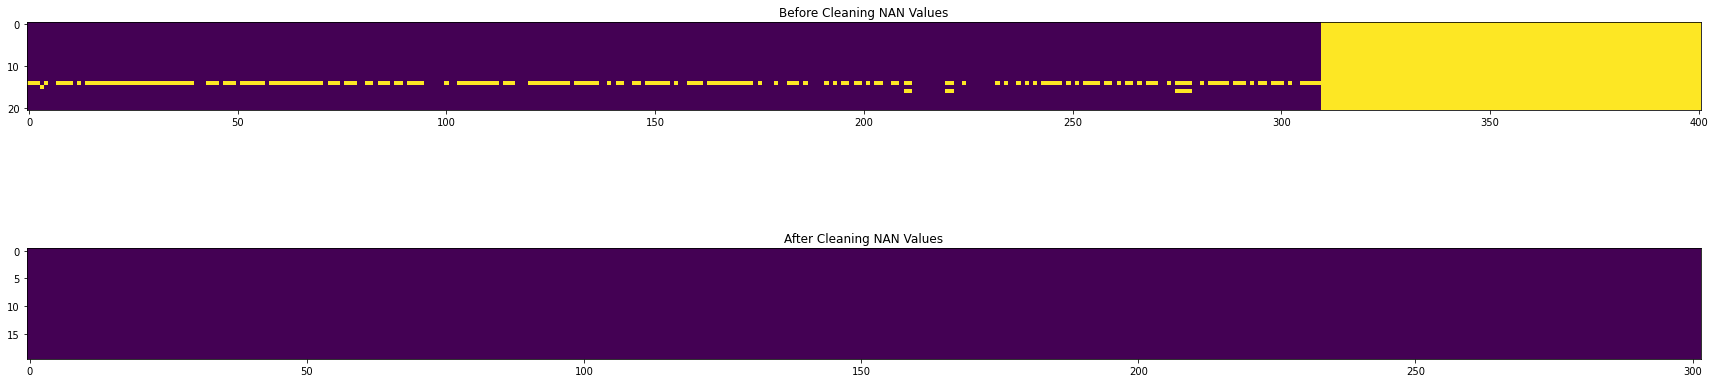

In [ ]:
#@title Visualizing NAN Values

plt.figure(figsize=(30,8))

ax = plt.subplot(2,1,1)
ax.set_title('Before Cleaning NAN Values')
plt.imshow(np.array(df.isnull()).T)

ax = plt.subplot(2,1,2)
ax.set_title('After Cleaning NAN Values')

plt.imshow(np.array(cleandf.isnull()).T)
plt.show()

In [ ]:
#@title OneHot Encoding 
X = cleandf.copy()
onehot_encoding_cols=['MaritalStatusID',
                      'EmpStatusID',
                      'DeptID',
                      'PositionID',
                      'ManagerID',
                      'TermReasonID',
                      'CitizenID',
                      'RaceID',
                      'RcrtmtSrcID']

for item in onehot_encoding_cols:
    temp = pd.get_dummies(X.pop(item), drop_first=True)
    X = pd.concat([temp,X],axis=1)

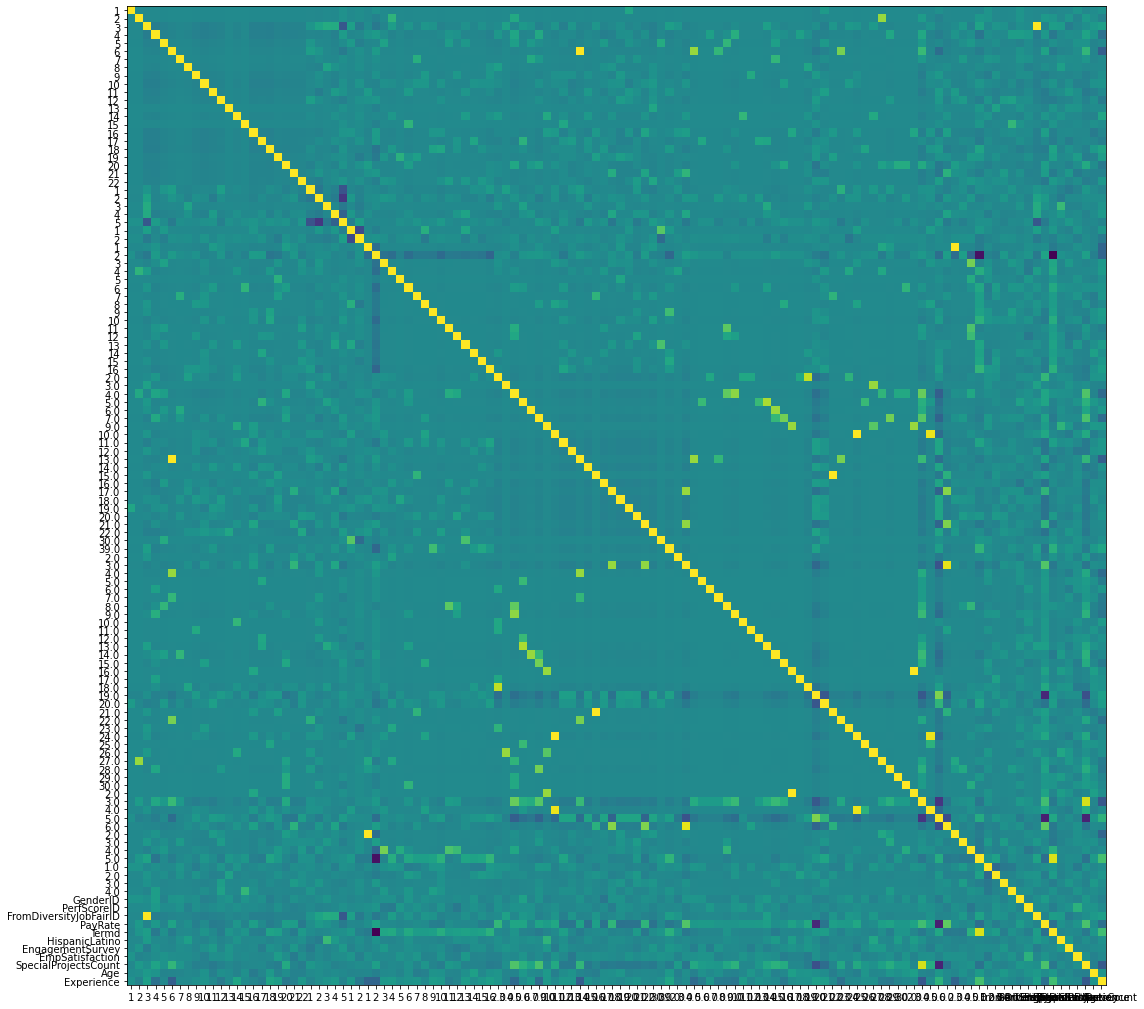

In [ ]:
#@title Columns Correlation Matrix
plt.figure(figsize=(18,18))
plt.subplot(1,1,1)
cols = X.corr().columns
plt.imshow(X.corr())
plt.yticks(np.arange(0, len(cols), 1), cols)
plt.xticks(np.arange(0, len(cols), 1), cols)
plt.show()

In [ ]:
#@title Train Test Split
y = X.pop('PayRate')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [ ]:
#@title Performing standardization before applying PCA
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

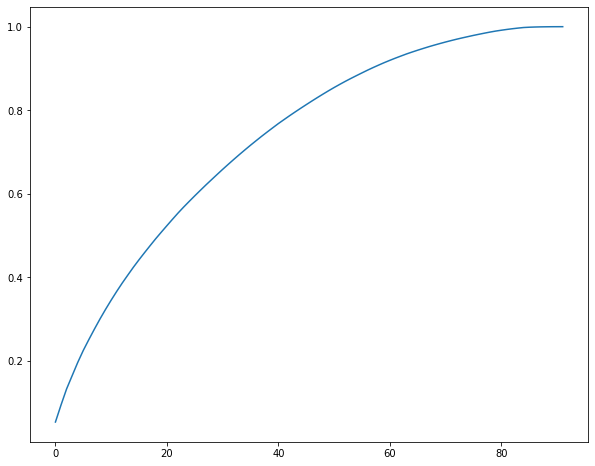

In [ ]:
#@title Dimensionality Reduction Fitting PCA
plt.figure(figsize=(10,8))

pca = PCA(n_components=92)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

plt.plot(np.cumsum(pca.explained_variance_ratio_))

## Training The First Neural Network

In [ ]:
inputs = layers.Input(shape=(92))
l_ = layers.Dense(64,activation='linear')(inputs)
l_ = layers.Dropout(0.1)(l_)
for i in range(8):
    
    l_ = layers.Dense(32,activation='linear')(l_)
    l_ = layers.Reshape((-1,1))(l_)
    l_ = layers.MaxPooling1D(pool_size=6,strides=2)(l_)
    l_ = layers.Flatten()(l_)
l_ = layers.Dense(8,activation='linear')(l_)
output = layers.Dense(1)(l_)

non_regularized_model = Model(inputs=inputs, outputs=output)
non_regularized_model.compile(optimizer="Adam", loss="mse")

# L1 Regularized Model
inputs = layers.Input(shape=(92))
l_ = layers.Dense(64,activation='linear')(inputs)
l_ = layers.Dropout(0.1)(l_)
for i in range(8):
    
    l_ = layers.Dense(32,activation='linear',kernel_regularizer=regularizers.l1(1e-4))(l_)
    l_ = layers.Reshape((-1,1))(l_)
    l_ = layers.MaxPooling1D(pool_size=6,strides=2)(l_)
    l_ = layers.Flatten()(l_)
l_ = layers.Dropout(0.3)(l_)
l_ = layers.Dense(8,activation='linear',kernel_regularizer=regularizers.l1(1e-4))(l_)
output = layers.Dense(1)(l_)

l1_regularized_model = Model(inputs=inputs, outputs=output)
l1_regularized_model.compile(optimizer="Adam", loss="mse")

In [ ]:
epochs = 32 #@param {type:"integer"}
non_regularized_model.fit(X_train, y_train, batch_size= 32,
          epochs=epochs,
          validation_data=(X_test,y_test),
          validation_batch_size=32,
          use_multiprocessing=True,
          workers=-1,
          verbose=0)

l1_regularized_model.fit(X_train, y_train, batch_size= 32,
          epochs=epochs,
          validation_data=(X_test,y_test),
          validation_batch_size=32,
          use_multiprocessing=True,
          workers=-1,
          verbose=0)

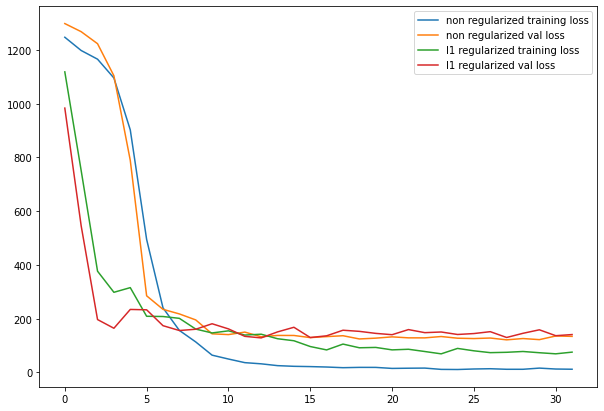

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(non_regularized_model.history.history['loss'],label = 'non regularized training loss')
plt.plot(non_regularized_model.history.history['val_loss'],label = 'non regularized val loss')
plt.plot(l1_regularized_model.history.history['loss'],label = 'l1 regularized training loss')
plt.plot(l1_regularized_model.history.history['val_loss'],label = 'l1 regularized val loss')
plt.legend()

In [ ]:
#@title Evaluation of The L1 Regularized Model and Non Regularized Model
print(np.sqrt(non_regularized_model.evaluate(X_test, y_test)))
print(np.sqrt(l1_regularized_model.evaluate(X_test, y_test)))

3/3 [==============================] - 0s 3ms/step - loss: 136.1756
11.669430723189555
3/3 [==============================] - 0s 3ms/step - loss: 137.9984
11.747273230189489


In [ ]:
#@title Evaluation of The Old Model (Assignment 2)
np.sqrt(oldmodel.evaluate(X_test, y_test))

3/3 [==============================] - 0s 2ms/step - loss: 93.2174


9.654915035274982

## Training The Second Neural Network

In [ ]:
inputs = layers.Input(shape=(92))
l_ = layers.Dense(64,activation='relu')(inputs)
l_ = layers.Dense(32,activation='relu')(l_)
l_ = layers.Dense(16,activation='relu')(l_)
l_ = layers.Dense(8,activation='linear')(l_)
output = layers.Dense(1)(l_)

non_regularized_model = Model(inputs=inputs, outputs=output)
non_regularized_model.compile(optimizer="Adam", loss="mse")

# L2 Regularized Model
inputs = layers.Input(shape=(92))
l_ = layers.Dense(64,activation='relu')(inputs)
l_ = layers.Dropout(0.1)(l_)
l_ = layers.Dense(32,activation='relu',kernel_regularizer=regularizers.l2(1e-5))(l_)
l_ = layers.Dense(16,activation='relu',kernel_regularizer=regularizers.l2(1e-5))(l_)
l_ = layers.Dropout(0.3)(l_)
l_ = layers.Dense(8,activation='linear')(l_)
output = layers.Dense(1)(l_)

l2_regularized_model = Model(inputs=inputs, outputs=output)
l2_regularized_model.compile(optimizer="Adam", loss="mse")

In [ ]:
epochs = 32 #@param {type:"integer"}
non_regularized_model.fit(X_train, y_train, batch_size= 32,
          epochs=epochs,
          validation_data=(X_test,y_test),
          validation_batch_size=32,
          use_multiprocessing=True,
          workers=-1)

l2_regularized_model.fit(X_train, y_train, batch_size= 32,
          epochs=epochs,
          validation_data=(X_test,y_test),
          validation_batch_size=32,
          use_multiprocessing=True,
          workers=-1)

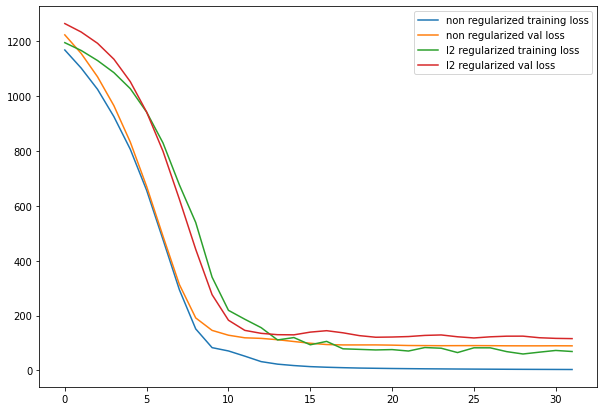

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(non_regularized_model.history.history['loss'],label = 'non regularized training loss')
plt.plot(non_regularized_model.history.history['val_loss'],label = 'non regularized val loss')
plt.plot(l2_regularized_model.history.history['loss'],label = 'l2 regularized training loss')
plt.plot(l2_regularized_model.history.history['val_loss'],label = 'l2 regularized val loss')
plt.legend()

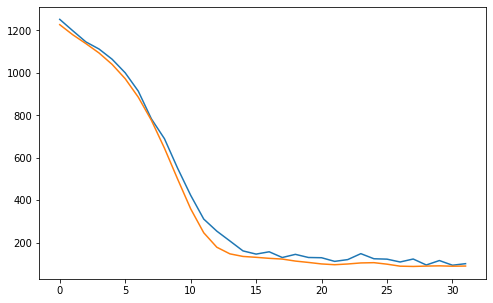

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])

In [ ]:
#@title Evaluation of The L2 Regularized Model and Non Regularized Model
print(np.sqrt(non_regularized_model.evaluate(X_test, y_test)))
print(np.sqrt(l2_regularized_model.evaluate(X_test, y_test)))

3/3 [==============================] - 0s 2ms/step - loss: 133.9108
11.571984602336746
3/3 [==============================] - 0s 2ms/step - loss: 115.8447
10.763116331097526


In [ ]:
#@title Evaluation of The Old Model (Assignment 2)
np.sqrt(model.evaluate(X_test, y_test))

3/3 [==============================] - 0s 2ms/step - loss: 90.1005


9.492127620052898